In [1]:
!pip install efficientnet-pytorch

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torchvision import datasets, transforms


# Define paths for train, validation, and test directories
train_dir = '/home/jovyan/Data Mining and Machine Learning/Dataset_New/train'
val_dir = '/home/jovyan/Data Mining and Machine Learning/Dataset_New/val'
test_dir = '/home/jovyan/Data Mining and Machine Learning/Dataset_New/test'

# Define Transforms and DataLoaders for training, validation, and testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for EfficientNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization values for ImageNet
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [2]:
# Training and Evaluation Code (including model, optimizer, and loss function setup)

LEARNING_RATE = 0.001
EPOCHS = 10

# Initialize EfficientNet model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)  # 2 classes: live and spoof
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Function
def train(model, loader):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluation Function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training Loop
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader)
    val_accuracy = evaluate(model, val_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Loaded pretrained weights for efficientnet-b0


/opt/conda/lib/python3.10/site-packages/efficientnet_pytorch/utils.py:275: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


Epoch [1/10], Loss: 0.1567, Validation Accuracy: 93.96%
Epoch [2/10], Loss: 0.0662, Validation Accuracy: 97.50%
Epoch [3/10], Loss: 0.0613, Validation Accuracy: 96.98%
Epoch [4/10], Loss: 0.0633, Validation Accuracy: 96.32%
Epoch [5/10], Loss: 0.0354, Validation Accuracy: 96.71%
Epoch [6/10], Loss: 0.0191, Validation Accuracy: 98.03%
Epoch [7/10], Loss: 0.0136, Validation Accuracy: 98.69%
Epoch [8/10], Loss: 0.0329, Validation Accuracy: 97.37%
Epoch [9/10], Loss: 0.0398, Validation Accuracy: 98.55%
Epoch [10/10], Loss: 0.0198, Validation Accuracy: 99.08%


In [3]:
# Test the model after training
test_accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'efficientnet_liveness_detection.pth')


Test Accuracy: 98.43%


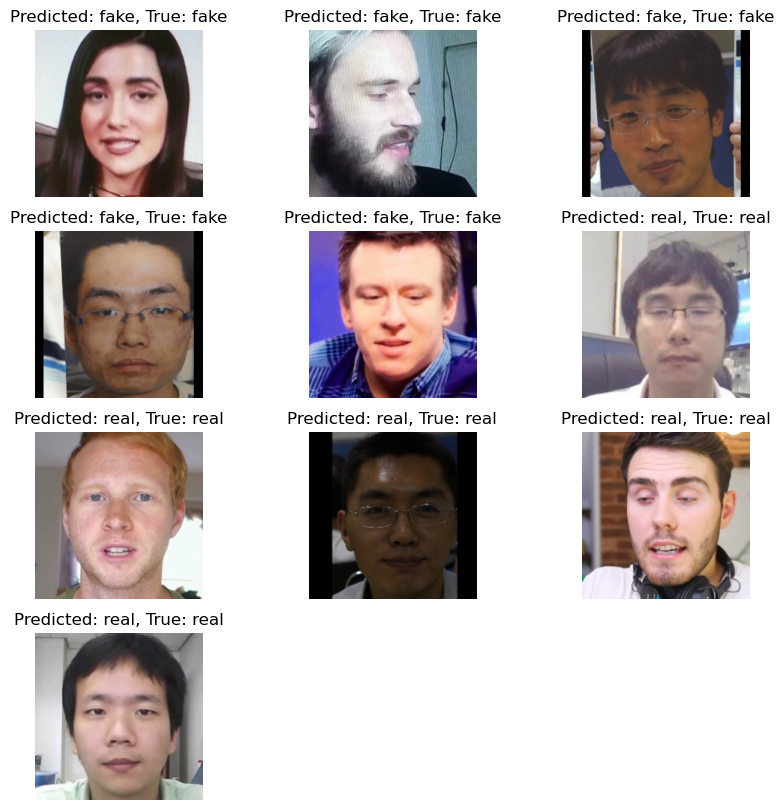

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

# Load the pretrained model and set to evaluation mode
model.eval()

# Class labels
class_names = [ 'fake','real']  # Assuming the class names are ['real', 'fake']

# Function to display an image with its predicted and true label
def display_image_with_prediction(image, predicted_label, true_label):
    # Unnormalize the image
    img = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    
    # Plot the image
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]}, True: {class_names[true_label]}")
    plt.axis('off')

# Collect predictions and actual labels for the entire test set
all_preds = []
all_labels = []
all_images = []

# Evaluate on the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions, actual labels, and images
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu())  # Store images for random selection

# Select a balanced random sample of images from each class for visualization
sample_indices = random.sample(
    [i for i in range(len(all_labels)) if all_labels[i] == 0], 5  # Real images
) + random.sample(
    [i for i in range(len(all_labels)) if all_labels[i] == 1], 5  # Fake images
)

# Display selected images with predictions
plt.figure(figsize=(10, 10))
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 3, i + 1)
    display_image_with_prediction(all_images[idx], all_preds[idx], all_labels[idx])
plt.show()


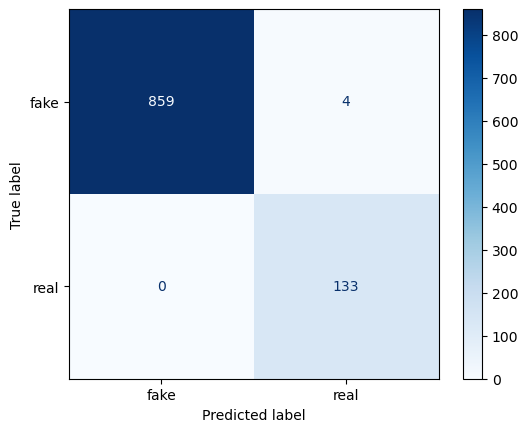

In [8]:

# Generate and display the confusion matrix for the entire test set
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.show()


## Inference single image

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


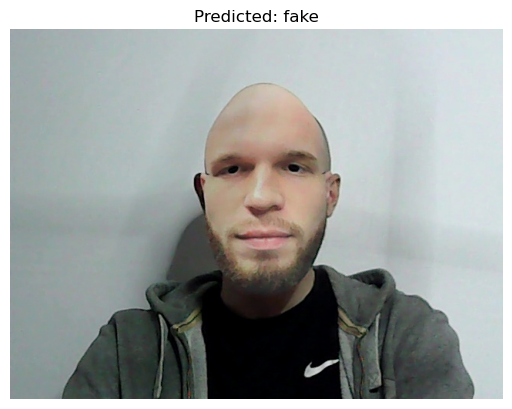

Inference time: 0.0040 seconds
Predicted label: fake


In [13]:
import torch
from torchvision import models, transforms  # Ensure models is imported
from PIL import Image
import matplotlib.pyplot as plt
import time  # Import time module

# Define the transformation for the input image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class labels
class_names = ['fake', 'real']  # Modify according to your dataset classes

def predict_image(image_path, model):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Preprocess the image
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Load the EfficientNet model
    model_path = '/home/jovyan/Data Mining and Machine Learning/efficientnet_liveness_detection.pth'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load the pretrained EfficientNet model and set it to evaluation mode
    model = models.efficientnet_b0(pretrained=False)  # Adjust based on the EfficientNet variant
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)  # Adjust for binary classification
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model = model.to(device)
    model.eval()

    # Measure the inference time
    start_time = time.time()  # Start the timer

    with torch.no_grad():
        output = model(image_tensor.to(device))  # Ensure the input is also on the correct device
        _, predicted = torch.max(output, 1)
    
    inference_time = time.time() - start_time  # Calculate the time taken for inference
    
    # Get the predicted label
    predicted_label = class_names[predicted.item()]
    
    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
    
    print(f"Inference time: {inference_time:.4f} seconds")  # Print the inference time
    
    return predicted_label

# Example usage
image_path = "/home/jovyan/Data Mining and Machine Learning/Dataset/test/fake/frame2_6.jpg"  # Replace with your image path
predicted_label = predict_image(image_path, model)
print(f"Predicted label: {predicted_label}")


## Average Inference Time per Image: 0.0001 seconds
